In [1]:
import numpy as np
import pandas as pd
import treePlotter

In [61]:
# 读取小费数据集
tips = pd.read_csv(r'C:\Users\vincen\Desktop\资料\Machine Learning\data\seaborn-data-master\tips.csv',
                   sep = ',',
                   encoding = 'utf-8',
                  header = 0,
                  engine = 'python')
# 划分训练集和测试集
# train_set = tips.sample(frac = 0.8,
#                         replace = False,
#                         axis = 0,
#                        random_state = 42)
# test_set = tips[~tips.index.isin(train_set.index)]
train_set = tips

In [64]:
display(tips.head())
display(tips.shape)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


(244, 7)

In [65]:
# 计算Gini指数(Regression中为样本方差)
def Gini(dataset,label_name = 'label'):
    '''
    parameters:
        dataset:数据集 DataFrame类型
        label_name:标签列的名称 str类型
    '''
    # 若DataFrame中样本数少于2,方法var()返回nan,此时方差应为0
    if dataset.shape[0] < 2:
        return 0
    # 若DataFrame中只有一个样本
    else:
        return dataset[label_name].var()*dataset.shape[0]

In [66]:
Gini(tips,label_name = 'tip')

467.1269316872433

In [67]:
# 按指定feature切分数据集
def spilt_dataset(dataset,spilt_feature,spilt_value = None):
    '''
    parameters:
        dataset:数据集 DataFrame类型
        spilt_feature:划分dataset的feature名称
        spilt_value:划分dataset的feature的划分点，可不填
    '''
    # 若spilt_value不为None，则按spilt_value与spilt_feature去划分dataset
    if spilt_value != None:
        group_dict = {}
        if dataset[spilt_feature].dtype == 'float':
            # 若属性为连续型，注意不需要删除属性列
            group_dict['$\leq$'+str(spilt_value)] = dataset[dataset[spilt_feature] <= spilt_value]
            group_dict['$>$'+str(spilt_value)] = dataset[dataset[spilt_feature] > spilt_value]
            return group_dict
        else:
            group_dict[str(spilt_value)] = dataset[dataset[spilt_feature] == spilt_value]
            group_dict['$\\neq$'+str(spilt_value)] = dataset[dataset[spilt_feature] != spilt_value]
            return group_dict
        
    # @@@@@CART不需要删除属性列
    if dataset[spilt_feature].dtype == 'float':
        dataset.sort_values(spilt_feature,inplace = True)
        groups = dataset.groupby(spilt_feature)
        # 获取各组的DataFrame
        groups = [group for name,group in groups]
        # 获取spilt_feature的所有可能的原始value
        init_spilt_feature_value = dataset[spilt_feature].unique()
        # 计算相邻两数的中间值,作为可能分界点用spilt_feature_value保存
        spilt_feature_value = []
        '''为可视化美观，保留一位小数'''
        for i in range(len(init_spilt_feature_value)):
            if i == 0:
                spilt_feature_value.append(round(init_spilt_feature_value[i],1))
            else:
                spilt_feature_value.append((round((init_spilt_feature_value[i] + init_spilt_feature_value[i-1])/2,1)))
        # 转化为ndarray
        spilt_feature_value = np.asarray(spilt_feature_value)
        # 建立分裂数据集字典
        group_dict = {}
        for value,group in zip(spilt_feature_value,groups):
            group_dict[value] = group
        return group_dict
    else:
        groups = dataset.groupby(spilt_feature)
        group_dict = {}
        # 用于保存spilt_feature的值，用以生成决策树的分支条件
        for name,group in groups:
            group_dict[name] = group
        # 返回划分好的属性集，以字典形式，value内是dataframe类型
        return group_dict

In [68]:
dataset = train_set
spilt_feature = 'total_bill'
print(dataset[spilt_feature].dtype == 'float')
print(len(spilt_dataset(train_set,spilt_feature)) == train_set[spilt_feature].unique().shape[0])
spilt_feature = 'sex'
dataset[spilt_feature].dtype
# spilt_dataset(train_set,spilt_feature)

True
False


dtype('O')

In [69]:
def select_best_feature(dataset,label_name = 'label'):
    # 获取属性名称并删除标签列
    feature_names = dataset.drop(label_name,inplace = False,axis = 1).columns
    # Gini_dict：用于记录每种属性使gini指数达到最小的属性取值
    Gini_dict = {}
    # 遍历所有属性列
    for feature in feature_names:
        # 按feature划分dataset
        group_dict = spilt_dataset(dataset,spilt_feature = feature)
        # 若属性为连续值
        if dataset[feature].dtype == 'float':
            # 获取分裂值
            key_list = np.asarray(list(group_dict.keys()),dtype = 'float')
            # 遍历key_list所有value
            Gini_list = []
            for key in key_list:
                # 小于等于当前分裂值的data记为group1
                group1 = dataset[dataset[feature] <= key]
                # 大于当前分裂值得data记为group2
                group2 = dataset[dataset[feature] > key]
                Gini_list.append(Gini(group1,label_name = label_name) + Gini(group2,label_name = label_name))
            Gini_dict[feature] = key_list[Gini_list.index(min(Gini_list))],min(Gini_list)
        else:
            # 获取分裂值
            key_list = np.asarray(list(group_dict.keys()))
            # 遍历key_list所有value
            Gini_list = []
            for key in key_list:
                # 等于当前分裂值的data记为group1
                group1 = dataset[dataset[feature] == key]
                # 不等于当前分裂值得data记为group2
                group2 = dataset[dataset[feature] != key]
                Gini_list.append(Gini(group1,label_name = label_name) + Gini(group2,label_name = label_name))
            Gini_dict[feature] = key_list[Gini_list.index(min(Gini_list))],min(Gini_list)
    # 获取各feature的最小gini值
    gini_value = []
    for tup in Gini_dict.values():
        gini_value.append(tup[1])
    # 从gini_value挑选出value最小的feature和分裂点
    best_feature,best_split_value = (list(Gini_dict.keys())[gini_value.index(min(gini_value))],
                                    list(Gini_dict.values())[gini_value.index(min(gini_value))][0]
                                    )
    return best_feature,best_split_value

In [70]:
# # 函数测试参数设置
# dataset = train_set
# label_name = 'tip'
# # 获取属性名称并删除标签列
# feature_names = dataset.drop(label_name,inplace = False,axis = 1).columns
# # Gini_dict：用于记录每种属性使gini指数达到最小的属性取值
# Gini_dict = {}
# # 遍历所有属性列
# for feature in feature_names:
#     # 按feature划分dataset
#     group_dict = spilt_dataset(dataset,spilt_feature = feature)
#     # 若属性为连续值
#     if dataset[feature].dtype == 'float':
#         # 获取分裂值
#         key_list = np.asarray(list(group_dict.keys()),dtype = 'float')
#         # 遍历key_list所有value
#         Gini_list = []
#         for key in key_list:
#             # 小于等于当前分裂值的data记为group1
#             group1 = dataset[dataset[feature] <= key]
#             # 大于当前分裂值得data记为group2
#             group2 = dataset[dataset[feature] > key]
#             Gini_list.append(Gini(group1,label_name = label_name) + Gini(group2,label_name = label_name))
#         Gini_dict[feature] = key_list[Gini_list.index(min(Gini_list))],min(Gini_list)
#     else:
#         # 获取分裂值
#         key_list = np.asarray(list(group_dict.keys()))
#         # 遍历key_list所有value
#         Gini_list = []
#         for key in key_list:
#             # 等于当前分裂值的data记为group1
#             group1 = dataset[dataset[feature] == key]
#             # 不等于当前分裂值得data记为group2
#             group2 = dataset[dataset[feature] != key]
#             Gini_list.append(Gini(group1,label_name = label_name) + Gini(group2,label_name = label_name))
#         Gini_dict[feature] = key_list[Gini_list.index(min(Gini_list))],min(Gini_list)
# # 获取各feature的最小gini值
# gini_value = []
# for tup in Gini_dict.values():
#     gini_value.append(tup[1])
# # 从gini_value挑选出value最小的feature和分裂点
# best_feature,best_split_value = (list(Gini_dict.keys())[gini_value.index(min(gini_value))],
#                                 list(Gini_dict.values())[gini_value.index(min(gini_value))][0]
#                                 )
# best_feature,best_split_value
select_best_feature(dataset,label_name = 'tip')

('total_bill', 20.3)

In [78]:
# 李航 统计学习方法 P70-P71
def RegressionTree(dataset,init_dataset = train_set,label_name = 'label',min_sample = 5,epsilon = 20):
    '''
    paramters:
        dataset:数据集
        init_dataset:第一次递归传入的数据集
        label_name:标签列的名称
        min_sample:叶子的最小样本数
        epsilon:GINI指数的阈值
    '''
    '''为可视化美观，返回结果保留一位小数'''
    # 若D中样本个数小于预定阈值,返回均值
    if dataset.shape[0] < min_sample:
        return round(dataset[label_name].mean(),1)
    # 若A = $\empty$ or D中样本在A上取值相同
    # 将结点标记为叶结点，其类别标记为D中样本最多的类
    if dataset.columns[0:-1].shape[0] == 0 or dataset.loc[:,dataset.columns[0:-1]].drop_duplicates().shape[0] == 1:
        # 返回D中样本均值
        return round(dataset[label_name].mean(),1)
    #若样本集的基尼指数小于预定阈值，返回均值
    if Gini(dataset,label_name = label_name) < epsilon:
        return round(dataset[label_name].mean(),1)
    #选择最优属性
    best_feature,best_spilt_value = select_best_feature(dataset,label_name = label_name)
    # 用最优属性划分D
    subdataset_dict = spilt_dataset(dataset,spilt_feature = best_feature,spilt_value = best_spilt_value)
    # 生成根节点
    dtree = {best_feature:{}}
    # 二叉生成
    for key in list(subdataset_dict.keys()):
        dtree[best_feature][key] = RegressionTree(subdataset_dict[key],label_name = label_name)
    return dtree

In [79]:
rtree = RegressionTree(train_set,label_name = 'tip')

C:\Users\vincen\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


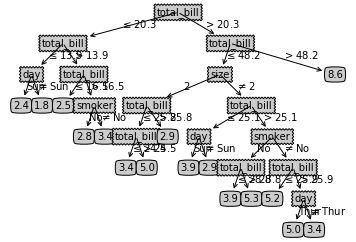

In [80]:
import matplotlib.pyplot as plt
plt.figure()
treePlotter.createPlot(rtree)

In [81]:
rtree

{'total_bill': {'$\\leq$20.3': {'total_bill': {'$\\leq$13.9': {'day': {'Sun': 2.4,
      '$\\neq$Sun': 1.8}},
    '$>$13.9': {'total_bill': {'$\\leq$16.5': 2.5,
      '$>$16.5': {'smoker': {'No': 2.8, '$\\neq$No': 3.4}}}}}},
  '$>$20.3': {'total_bill': {'$\\leq$48.2': {'size': {'2': {'total_bill': {'$\\leq$25.8': {'total_bill': {'$\\leq$24.5': 3.4,
          '$>$24.5': 5.0}},
        '$>$25.8': 2.9}},
      '$\\neq$2': {'total_bill': {'$\\leq$25.1': {'day': {'Sun': 3.9,
          '$\\neq$Sun': 2.9}},
        '$>$25.1': {'smoker': {'No': {'total_bill': {'$\\leq$28.8': 3.9,
            '$>$28.8': 5.3}},
          '$\\neq$No': {'total_bill': {'$\\leq$25.9': 5.2,
            '$>$25.9': {'day': {'Thur': 5.0, '$\\neq$Thur': 3.4}}}}}}}}}},
    '$>$48.2': 8.6}}}}